In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
from glob import glob
import yaml

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

import intake

import regrid_tools
import config
import util

# Read FOSI simulation

Run details from README
```text
Monthly restarts for POP & CICE come from a modified* OMIP2 (JRA55-do forcing) spinup (6 cycles)
FOSI (forced ocean--sea-ice) simulation. Details of this simulation are as follows:
    - CASE: g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005
    - CASEROOT: /glade/work/klindsay/cesm22_cases/SMYLE/$CASE
    - SRCROOT: /glade/work/klindsay/cesm2_tags/cesm2.2.0/
    - forcing:  JRA55-do v1.4, 1958-2018 (==> 61-year cycle)
    - spinup: 6 cycles (==> simyears 0001-0366)
    - years used for SMYLE ICs:   0306 (1958) - 0366 (2018)

* Modifications from CMIP6-OMIP2 were made to improve sea-ice and ocean BGC fields:
    -Use of full 1958-2018 (61-year) forcing cycle during spinup
    -Use of strong under-ice restoring to model prognostic freezing temperature (TFZ)
    -Reduced deep isopycnal mixing (kappa_isop_deep = 0.1, instead of CESM2-default of 0.2)
    -Enhanced sea ice albedoes:
            r_snw = 1.6
            dt_mlt = 0.5
            rsnw_mlt = 1000.
```

In [5]:
year_range = 1990, 2020

In [6]:
src_grid = regrid_tools.grid("POP_gx1v7")
src_grid

exists: /glade/scratch/mclong/tmp/regridding/POP_gx1v7.nc


grid: POP_gx1v7
dims: (384, 320)
file: /glade/scratch/mclong/tmp/regridding/POP_gx1v7.nc

In [7]:
dst_grid = regrid_tools.grid("latlon", **config.config_dict["flux-dst-grid-kwargs"])
dst_grid

exists: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc


grid: latlon_latlon_1.0x1.0_lon0=-180.0
dims: (180, 360)
file: /glade/scratch/mclong/tmp/regridding/latlon_1.0x1.0_lon0=-180.0.nc

In [8]:
regrid_obj = regrid_tools.regridder(src_grid, dst_grid, method="conserve", clobber=False)
regrid_obj

source grid dims: (384, 320)
destination grid dims: (180, 360)


regridder POP_gx1v7.nc --> latlon_1.0x1.0_lon0=-180.0.nc

In [9]:
dso_grid = util.generate_latlon_grid(**config.config_dict["flux-dst-grid-kwargs"])[["area"]]
dso_grid

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    area     (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08 1.079e+08

In [10]:
time_daily, time_daily_bnds = util.gen_daily_cftime_coord(year_range)
time_daily_num = cftime.date2num(time_daily, time_daily.encoding['units'])
time_daily

<xarray.DataArray 'time' (time: 11323)>
array([cftime.DatetimeGregorian(1990, 1, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1990, 1, 2, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1990, 1, 3, 12, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(2020, 12, 29, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2020, 12, 30, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(2020, 12, 31, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Dimensions without coordinates: time
Attributes:
    bounds:   time_bnds

In [11]:
curator = util.curate_flux_products()
curator

{'description': 'Flux products for transport modeling', 'plugins': {'source': [{'module': 'intake_xarray'}]}, 'sources': {'fgapo.carboscope.apo99_v2020': {'args': {'urlpath': '/glade/work/mclong/sno-analysis/flux-products/fgapo_ocn.CarboScope.apo99_v2020.nc', 'xarray_kwargs': {'decode_times': False}}, 'description': 'APO fluxes from CarboScope inversion apo99_v2020', 'driver': 'netcdf'}, 'fgco2.MPI-SOM-FFN': {'args': {'urlpath': '/glade/work/mclong/sno-analysis/flux-products/fgco2.MPI-SOM-FFN.v2021.199501-202012.nc', 'xarray_kwargs': {'decode_times': False}}, 'description': 'An observation-based global monthly gridded sea surface pCO2 product from 1982 onward and its monthly climatology. Citation: Landschützer, P., Gruber, N., Bakker, D. C. E.: Decadal variations and trends of the global ocean carbon sink, Global Biogeochemical Cycles, 30, doi:10.1002/2015GB005359, 2016', 'driver': 'netcdf'}, 'fgco2.ODIAC-FF.OCO2-MIP': {'args': {'urlpath': '/glade/work/mclong/sno-analysis/flux-products

In [12]:
cluster, client = util.get_ClusterClient()
cluster.scale(12)

client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.34:41120,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/calcs/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
year_offset = 2018 - 366
year_offset

1652

In [14]:
%%time
clobber = False

path = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries'
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005'

xr_open_kwargs = dict(chunks={'nlat': 16}, 
                      decode_coords=False, 
                      decode_times=False,
                     )

cesm_varnames = {
    "fgco2": {"varname": "FG_CO2_2", "freq": "day_1", "stream": "pop.h.ecosys.nday1"},
    "fgo2": {"varname": "STF_O2_2", "freq": "day_1", "stream": "pop.h.ecosys.nday1"},
    "fgn2": {"varname": ["SHF", "SALT", "TEMP"], "freq": "month_1", "stream": "pop.h"},
}



nmolcm2s_molm2s = 1e-9 * 1e4

variables = ['fgco2', 'fgo2', 'fgn2']

fgn2_scaleby = 1 / 1.3

dsets = {}
for v in variables:
    
    # output file
    file_out = f"{config.flux_product_dir}/{v}.{case}.{year_range[0]}0101-{year_range[1]}1231.nc"    
    
    if os.path.exists(file_out) and not clobber:
        print(f'exists: {file_out}')
        dsets[v] = xr.open_dataset(file_out)
        continue

    # get variable, stream and frequency
    varname = cesm_varnames[v]['varname']
    stream = cesm_varnames[v]['stream'] 
    freq = cesm_varnames[v]['freq']
    
    if freq == 'day_1':
        freq_str = 'daily'
        dateglob = '????????-????????'
    elif freq == 'month_1':
        freq_str = 'monthly'        
        dateglob = '??????-??????'
    

    # if varname is a list, assume it's a derived variable
    if isinstance(varname, list):
        ds_list = []
        for varname_i in varname:
            file = sorted(glob(f'{path}/{freq}/{case}.{stream}.{varname_i}.{dateglob}.nc'))
            assert len(file) == 1   
            ds_list.append(xr.open_dataset(file[0], **xr_open_kwargs))
        ds = xr.merge(ds_list)
        
        if v == 'fgn2':
            ds = ds.isel(z_t=0, drop=True).rename({'SHF': 'hfds', 'SALT': 'sos', 'TEMP': 'tos'})
            ds = util.compute_fgn2(ds, scaleby=fgn2_scaleby).drop(['hfds', 'sos', 'tos'])
            ds.fgn2.attrs['units'] = 'mol/m^2/s'
        
        # append Jan from the last year of the simulation
        # so that the interpolation doesn't yeild NaNs
        if freq == 'month_1':
            assert 'days since' in ds.time.attrs['units']
            ds_jan_last = ds.isel(time=[-12])
            ds_jan_last['time'] = ds_jan_last.time + 365.
            ds_jan_last['time_bound'][0, :] = ds_jan_last.time_bound[0, :] + 365.
            ds = xr.concat((ds, ds_jan_last), dim='time')
    else:
        file = sorted(glob(f'{path}/{freq}/{case}.{stream}.{varname}.{dateglob}.nc'))
        assert len(file) == 1           
        ds = xr.open_dataset(file[0], **xr_open_kwargs).rename({varname: v})
    
    time_bounds = ds[ds.time.bounds]

    # add year offset, change calendar to gregorian
    time_noleap = cftime.num2date(time_bounds.mean(axis=1), units=ds.time.units, calendar=ds.time.calendar)
    time_components = util.gen_time_components_variable(time_noleap, year_offset)
    
    time_gregorian_date = [
        cftime.DatetimeGregorian(*time_components[i, :]) 
        for i in range(time_components.shape[0])
    ]    
    time_gregorian_num = cftime.date2num(time_gregorian_date, units=time_daily.encoding['units'])
    ds['time'] = xr.DataArray(time_gregorian_num, dims=('time'))

    # interpolate to daily time (with leap days)
    ds = ds.interp(time=time_daily_num)
    ds['time'] = time_daily

    # subset variable, reverse sign convention
    ds = ds[[v]]    
    if v in ['fgco2', 'fgo2',]:
        with xr.set_options(keep_attrs=True):
            ds[v] = -1.0 * nmolcm2s_molm2s * ds[v]
        ds[v].attrs['units'] = 'mol/m^2/s'
    
    # regrid
    dso = regrid_obj(ds.compute())
    dso[v] = dso[v].rename({'nlat': 'lat', 'nlon': 'lon'})    
    for attr in ['coordinates', 'grid_loc', 'cell_methods']:
        if attr in dso[v].attrs:
            del dso[v].attrs[attr]
        
    dso["time"] = ds.time    
    dso[ds.time.bounds] = time_daily_bnds
    dso['lat'] = dso_grid['lat']
    dso['lon'] = dso_grid['lon']    
    dso['area'] = dso_grid['area']    

    # clean up attributes
    attrs_keys = list(dso.attrs.keys())
    for attr in attrs_keys:
        if attr not in ['model_doi_url']:
            del dso.attrs[attr]
    dso.attrs['source'] = case
    dso.attrs['note'] = 'Leap day values are linearly interpolated from adjacent data'

    # remove existing output
    if os.path.exists(file_out):
        print(f'removing: {file_out}')        
        os.remove(file_out)
    
    util.to_netcdf_clean(dso, file_out)
    
    dsets[v] = dso
    curator.add_source(
        key=f"{v}.cesm_fosi_smyle",
        urlpath=file_out,
        description=f'CESM simulated flux from {case} at {freq_str} resolution',
    )
    

------------------------------
Writing /glade/work/mclong/sno-analysis/flux-products/fgco2.g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.19900101-20201231.nc
netcdf fgco2.g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.19900101-20201231 {
dimensions:
	lon = 360 ;
	lat = 180 ;
	time = 11323 ;
	d2 = 2 ;
variables:
	double lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
	double lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "Latitude" ;
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1990-01-01" ;
		time:calendar = "gregorian" ;
	float fgco2(time, lat, lon) ;
		fgco2:_FillValue = 9.96921e+36f ;
		fgco2:long_name = "DIC Surface Gas Flux" ;
		fgco2:units = "mol/m^2/s" ;
	double time_bnds(time, d2) ;
	float area(lat, lon) ;
		area:_FillValue = 9.96921e+36f ;
		area:units = "m^2" ;
		area:long_name = "area" ;

// global attributes:
		:model_doi_url = "https://doi.org/10.5065/D67H1H0V" ;
		:source = "g.e22.GOMIPECOIA

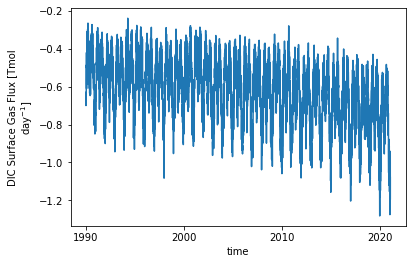

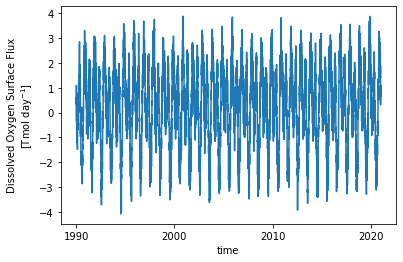

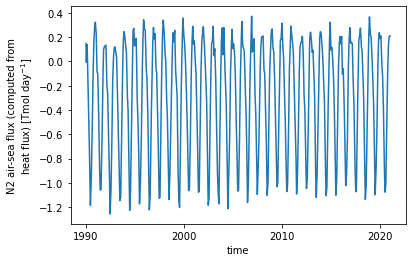

In [15]:
for key, dsi in dsets.items():    
    v = key
    plt.figure()
    with xr.set_options(keep_attrs=True):    
        global_sum = ((dsi[v] * dsi.area).sum(['lat', 'lon'])) * 1e-12 * 86400.
        global_sum.attrs['units'] = 'Tmol day$^{-1}$'
    global_sum.plot()

In [16]:
client.close()
cluster.close()